# Multitask

Recognizing variety -> recognizing disease

After changing head notebook, here is an easier way to do it.

In [1]:
from copy import copy, deepcopy
from fastai.vision.all import *
from fastcore.parallel import *
path = Path()
trn_path = path/'train_images'

In [2]:
df = pd.read_csv('train.csv')
df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


Turning DataLoaders into DataBlocks. We need to return 2 outputs, variety and disease.

In [3]:
img2variety = { r.image_id:r.variety for _,r in df.iterrows() }

In [4]:
# making it as a function
img2variety['100330.jpg'] == img2variety.__getitem__('100330.jpg')

True

In [5]:
def get_variety(p):
    "Turn path into image name"
    return img2variety[p.name]

In [6]:
dblock = DataBlock(
    blocks=(ImageBlock, CategoryBlock, CategoryBlock),
    n_inp=1,                                                 # Have to tell how many inputs
    get_items=get_image_files,
    get_y=[parent_label, get_variety],
    splitter=RandomSplitter(seed=42),
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(size=128, min_scale=0.75)
)

In [21]:
# Starting with dataset for easier debugging
dss = dblock.datasets(trn_path)

In [24]:
dss.train[0]

(PILImage mode=RGB size=192x256, TensorCategory(8), TensorCategory(6))

Here's what's going on behinde the scenes on DataBlock:

In [26]:
fn = get_image_files(trn_path)[0]
fn

Path('train_images/bacterial_panicle_blight/109162.jpg')

In [31]:
PILImage.create(fn), parent_label(fn), get_variety(fn)

(PILImage mode=RGB size=192x256, 'bacterial_panicle_blight', 'ADT45')

Very cool!

Simplest DataBlock ever!

In [32]:
dblock = DataBlock(
    blocks=(TransformBlock),      # The simplest Block
    get_items=get_image_files,
)

In [35]:
dss = dblock.datasets(trn_path)
# Tuple of number of TransformBlocks
dss[0]

(Path('train_images/bacterial_panicle_blight/109162.jpg'),)

In [43]:
dblock = DataBlock(
    blocks=(TransformBlock,TransformBlock),      # The simplest Block
    get_items=get_image_files,
    get_x=lambda o: o.name,
    get_y=lambda o: o.parent.name,
)

In [41]:
dss = dblock.datasets(trn_path)
# Tuple of number of TransformBlocks
dss[0]

('109162.jpg', 'bacterial_panicle_blight')

In [49]:
dblock = DataBlock(
    blocks=(TransformBlock(type_tfms=[lambda o: o.name]),TransformBlock,TransformBlock), 
    get_items=get_image_files,
    n_inp=1,
    get_y=[lambda o: o.parent.name, lambda o: o.parent.parent.name],
)

In [50]:
dss = dblock.datasets(trn_path)
# Tuple of number of TransformBlocks
dss[0]

('109162.jpg', 'bacterial_panicle_blight', 'train_images')

Order:

1. `get_x` or `get_y`
2. `TransformBlock`'s type_tfms on `DataSets`
3. `TransformBlock`'s item_tfms on `DataLoaders`

In [52]:
# This is how ImageBlock is transfromed into
dblock = DataBlock(
    blocks=(TransformBlock(type_tfms=PILImage.create, batch_tfms=IntToFloatTensor),TransformBlock,TransformBlock), 
    get_items=get_image_files,
    n_inp=1,
    get_y=[lambda o: o.parent.name, lambda o: o.parent.parent.name],
)

In [53]:
dss = dblock.datasets(trn_path)
# Tuple of number of TransformBlocks
dss[0]

(PILImage mode=RGB size=192x256, 'bacterial_panicle_blight', 'train_images')

In [54]:
# CategoryBlock turns strings into dictionary lookups so that they can be turned into tensors.
dblock = DataBlock(
    blocks=(ImageBlock,CategoryBlock,CategoryBlock), 
    get_items=get_image_files,
    n_inp=1,
    get_y=[lambda o: o.parent.name, lambda o: o.parent.parent.name],
)

In [55]:
dss = dblock.datasets(trn_path)
dss[0]

(PILImage mode=RGB size=192x256, TensorCategory(2), TensorCategory(0))

In [56]:
dss.vocab

(#2) [['bacterial_leaf_blight', 'bacterial_leaf_streak', 'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart', 'downy_mildew', 'hispa', 'normal', 'tungro'],['train_images']]

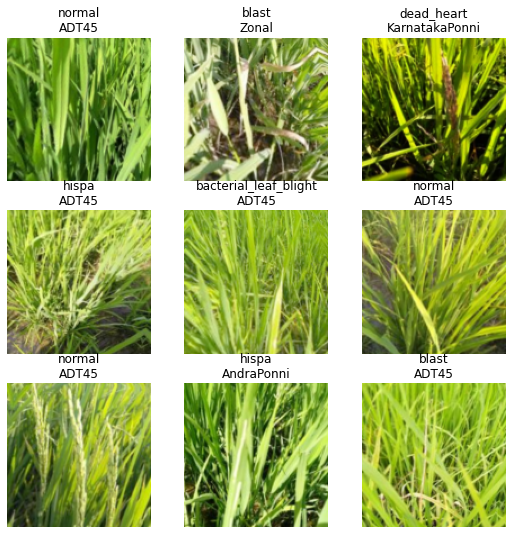

In [7]:
dls = dblock.dataloaders(trn_path)
dls.show_batch()

## Changing the head

In [40]:
# Grab a model
m = learn.model

In [41]:
h = m[1]
ll = h[-1]
del(h[-1])

Time to create a new layer for the head.

In [42]:
class DiseaseAndTypeClassifier(nn.Module):
    def __init__(self, m):
        super().__init__()
        self.l1 = nn.Linear(512, 10, bias=False) # variety of rice
        self.l2 = nn.Linear(512, 10, bias=False) # type of disease
        self.m = m
    
    def forward(self, x):
        x = self.m(x)
        x1 = self.l1(x)
        x2 = self.l2(x)
        return x1, x2